# Progetto d'esame di Data Analysis in Experimental Physics with Machine Learning

Gruppo composto dagli studenti Luca Attinà, Sharis Feriotto e Matteo Marchisio Caprioglio

Dataset ipotesi: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
Questo dataset non va bene perchè ha fatto data aug sul validation dataset, fallback al plant village originale: https://www.tensorflow.org/datasets/catalog/plant_village

In [8]:
import os
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [9]:
print(tf.config.list_physical_devices('GPU'))


[]


In [10]:
# Seed setting for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

# Data download and preprocess

In [11]:
COLAB = False  # if True, run on Google Colab, else on local repository

In [12]:
# useful constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
N_EPOCHS = 20
VERBOSE = True

IF RUNNING ON COLAB

In [13]:
# Load the PlantVillage dataset from TFDS instead of the new dataset (it performed data aug on the validation set, which is wrong)
def load_from_tfds():
    # if running on Google Colab
    (ds_train, ds_val, ds_test), ds_info = tfds.load(
        'plant_village',
        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
        shuffle_files=True,
        as_supervised=True,  # returns (image, label) pairs
        with_info=True,
    )

    class_names = ds_info.features['label'].names

    families = sorted({n.split('___')[0] for n in class_names})
    split_labels = families
    family_map = tf.constant([families.index(n.split('___')[0]) for n in class_names], dtype=tf.int32)

    def to_ohe(img, lbl):
      idx = tf.gather(family_map, lbl)
      return img, tf.one_hot(idx, len(split_labels))

    ds_train = ds_train.map(to_ohe)
    ds_val   = ds_val.map(to_ohe)
    ds_test  = ds_test.map(to_ohe)

    print(class_names)

    return ds_train, ds_val, ds_test, split_labels, ds_info

In [14]:
if COLAB:
    def preprocess(image, label, image_size=(128, 128)):
        image = tf.image.resize(image, image_size)
        image = tf.cast(image, tf.float32) / 255.0
        return image, label

IF RUNNING ON LOCAL REPOSITORY

In [15]:
from pathlib import Path
from preprocessing import preprocess

base_path = Path(r"D:\progetto-daml\PlantVillage-Dataset")
OUTPUT_ROOT = base_path / "by_family"
DS_DIR = OUTPUT_ROOT / "train"

In [16]:
def prepare_local_dataset():
    split_labels = sorted([p.name for p in (OUTPUT_ROOT/"train").iterdir() if p.is_dir()])

    ds_train_ohe = tf.keras.utils.image_dataset_from_directory(
        str(OUTPUT_ROOT/"train"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,  # mescola le immagini
        label_mode='categorical',  # ottieni one-hot su len(families)
    )

    ds_val_ohe = tf.keras.utils.image_dataset_from_directory(
        str(OUTPUT_ROOT/"val"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=True,
    )

    ds_test_ohe = tf.keras.utils.image_dataset_from_directory(
        str(OUTPUT_ROOT/"test"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=True,
    )

    return ds_train_ohe, ds_val_ohe, ds_test_ohe, split_labels

# Training


In [17]:
from keras.models import Sequential, Model
from keras.layers import Resizing, Activation, BatchNormalization, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D, ReLU, Rescaling
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy

from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import regularizers

In [18]:
def simple_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(16, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.2),

        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        #Conv2D(128, (3, 3), padding='same'),
        #BatchNormalization(),
        #Activation('relu'),
        #MaxPooling2D((2, 2)),
        #Dropout(0.3),

        Flatten(),
        #Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [19]:
def model_preprocess(COLAB):
    if COLAB:
        ds_train, ds_val, ds_test, split_labels, ds_info = load_from_tfds()
        ds_train = ds_train.map(lambda img, lbl: preprocess(img, lbl, IMG_SIZE)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset without data augmentation
        ds_val = ds_val.map(lambda img, lbl: preprocess(img, lbl, IMG_SIZE)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        ds_test = ds_test.map(lambda img, lbl: preprocess(img, lbl, IMG_SIZE)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        '''if VERBOSE:
          tfds.show_examples(ds_train, ds_info)'''
    else:
        ds_train, ds_val, ds_test, split_labels = prepare_local_dataset()


    # Preprocess and batch the datasets

    num_classes = len(split_labels)
    tag = "14_families"
    checkpoint = f"best_model_{tag}.h5"

    return ds_train, ds_val, ds_test, split_labels, num_classes, checkpoint



In [20]:
def model_train(num_classes):
    model = simple_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=num_classes)

    optimizer = Adam(learning_rate=0.001)
    # optimizer = SGD(learning_rate=0.05, momentum=0.9)
    model.compile(
        optimizer=optimizer,
        loss=CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    model.build(input_shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3))  # Build the model with dynamic batch size
    model.summary()
    return model


In [21]:
train_set, val_set, test_set, split_labels, num_classes, checkpoint_file = model_preprocess(COLAB)

Found 43429 files belonging to 14 classes.
Found 5417 files belonging to 14 classes.
Found 5459 files belonging to 14 classes.


In [22]:
print(split_labels)
print(len(split_labels))
print(checkpoint_file)

['Apple', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Orange', 'Peach', 'Pepper,_bell', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']
14
best_model_14_families.h5


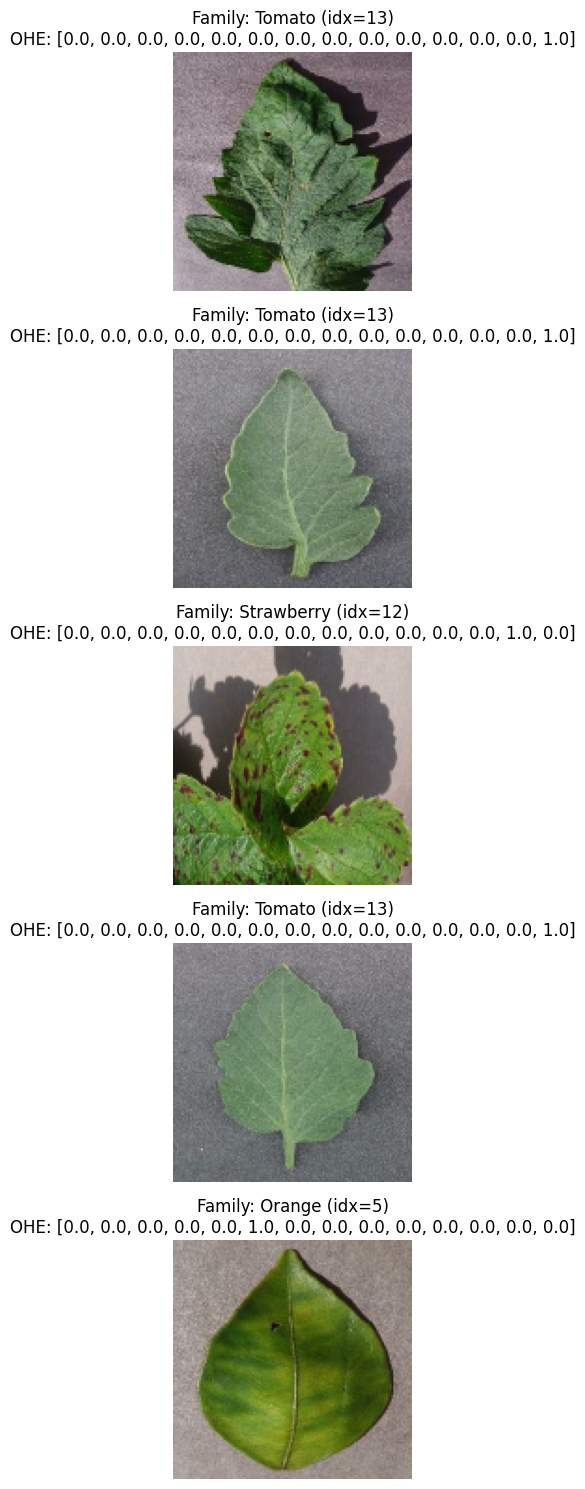

In [23]:
# Assicurati di avere la lista 'families' definita, per es.:
# families = ['Apple', 'Blueberry', …]  # lunghezza NUM_FAM

def display_samples_with_labels_ohe(dataset, num_samples=5):
    plt.figure(figsize=(6, 3 * num_samples))
    for i, (img, label_ohe) in enumerate(dataset.unbatch().take(num_samples)):
        # Converte i tensori in NumPy
        img_np   = img.numpy().astype("uint8")
        ohe_vec  = label_ohe.numpy()                     # vettore one-hot
        fam_idx  = int(tf.argmax(label_ohe).numpy())     # indice famiglia
        fam_name = split_labels[fam_idx]

        # Plot
        ax = plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img_np)
        plt.axis("off")
        plt.title(f"Family: {fam_name} (idx={fam_idx})\nOHE: {ohe_vec.tolist()}")
    plt.tight_layout()
    plt.show()

# Esempio d’uso:
display_samples_with_labels_ohe(train_set, num_samples=5)


In [24]:
from collections import Counter

# Usa Counter per efficienza in memoria e velocità
counts = Counter()

for _, batch_labels in train_set:
    # batch_labels.numpy() ha shape (batch_size, num_classes)
    idxs = np.argmax(batch_labels.numpy(), axis=1)  # shape (batch_size,)
    counts.update(idxs)

print(f"Number of classes: {len(split_labels)}")
print("Number of images per class:")
for idx in range(len(split_labels)):
    print(f"{split_labels[idx]}: {counts[idx]} images")

Number of classes: 14
Number of images per class:
Apple: 2536 images
Blueberry: 1201 images
Cherry: 1524 images
Corn: 3080 images
Grape: 3248 images
Orange: 4405 images
Peach: 2125 images
Pepper,_bell: 1979 images
Potato: 1721 images
Raspberry: 296 images
Soybean: 4072 images
Squash: 1468 images
Strawberry: 1251 images
Tomato: 14523 images


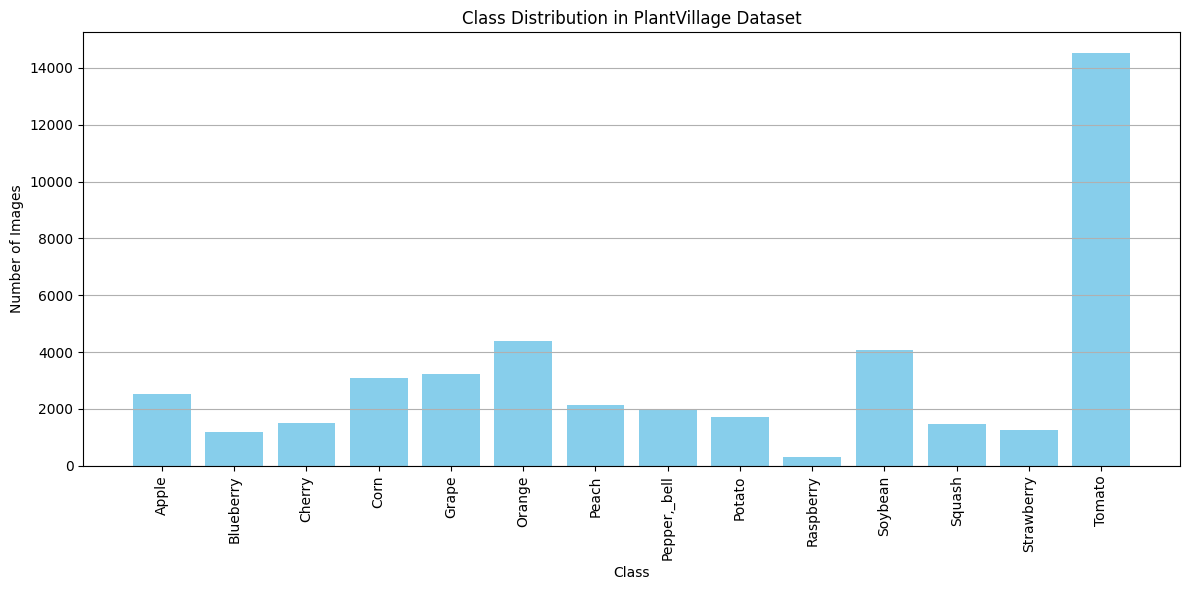

In [25]:
# Visualize the class distribution
counts_list = [counts[i] for i in range(len(split_labels))]

plt.figure(figsize=(12, 6))
plt.bar(split_labels, counts_list, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in PlantVillage Dataset')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [26]:
# Element format
print("Element spec:", train_set.element_spec)

# Example on a batch
for batch in train_set.take(1):
    x, y = batch
    print("x shape:", x.shape, "  dtype:", x.dtype)
    print("y shape:", y.shape, "  dtype:", y.dtype)


Element spec: (TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.float32, name=None))
x shape: (32, 128, 128, 3)   dtype: <dtype: 'float32'>
y shape: (32, 14)   dtype: <dtype: 'float32'>


In [27]:
model = model_train(num_classes)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │     1,835,022 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,840,302 (7.02 MB)

 Trainable params: 1,840,206 (7.02 MB)

 Non-trainable params: 96 (384.00 B)

In [28]:
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=N_EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        ModelCheckpoint(checkpoint_file, monitor='val_loss', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    ]
)

Epoch 1/20
 238/1358 ━━━━━━━━━━━━━━━━━━━━ 8:35 460ms/step - accuracy: 0.4620 - loss: 31.1165

KeyboardInterrupt: 

In [ ]:
#DECOMMENT IF DATASET IS NOT SPLIT YET
'''
if FAM_SPLIT:
    # 1) Configurazione
    #SOURCE_DIR   = Path(r"D:\progetto-daml\PlantVillage-Dataset\raw\color")
    #OUTPUT_ROOT  = Path(r"D:\progetto-daml\PlantVillage-Dataset\by_family")
    OUTPUT_ROOT  = Path(r"/home/luchino/Desktop/ProgettoML/Dataset/by_family")
    TRAIN_FRAC   = 0.8
    VAL_FRAC     = 0.1
    TEST_FRAC    = 0.1
    SEED         = 42

    random.seed(SEED)

    # 2) Crea le directory di output
    for split in ("train","val","test"):
        (OUTPUT_ROOT / split).mkdir(parents=True, exist_ok=True)

    # 3) Raccogli classi di disease e mappa a famiglia
    disease_folders = sorted([d for d in SOURCE_DIR.iterdir() if d.is_dir()])
    families = sorted({d.name.split("___")[0] for d in disease_folders})

    # 4) Prepara le cartelle per ogni famiglia e split
    for split in ("train","val","test"):
        for fam in families:
            (OUTPUT_ROOT/ split / fam).mkdir(parents=True, exist_ok=True)

    # 5) Per ogni disease, raccogli i file e spartiscili
    for disease_dir in disease_folders:
        fam = disease_dir.name.split("___")[0]
        images = list(disease_dir.glob("*.*"))  # tutti i file immagine
        random.shuffle(images)

        n = len(images)
        n_train = int(n * TRAIN_FRAC)
        n_val   = int(n * VAL_FRAC)
        # il resto va in test
        train_imgs = images[:n_train]
        val_imgs   = images[n_train:n_train+n_val]
        test_imgs  = images[n_train+n_val:]

        # copia fisica in output_root/<split>/<fam>/
        for img in train_imgs:
            shutil.copy(img, OUTPUT_ROOT/"train"/fam/img.name)
        for img in val_imgs:
            shutil.copy(img, OUTPUT_ROOT/"val"/fam/img.name)
        for img in test_imgs:
            shutil.copy(img, OUTPUT_ROOT/"test"/fam/img.name)

    print("Done! I tuoi dati sono ora in:\n",
        OUTPUT_ROOT / "train", OUTPUT_ROOT / "val", OUTPUT_ROOT / "test")

else:
    OUTPUT_ROOT  = Path(r"/home/luchino/Desktop/ProgettoML/Dataset/by_disease")
    TRAIN_FRAC   = 0.8
    VAL_FRAC     = 0.1
    TEST_FRAC    = 0.1
    SEED         = 42

    random.seed(SEED)

    # 2) Crea le directory di output (train, val, test)
    for split in ("train","val","test"):
        (OUTPUT_ROOT / split).mkdir(parents=True, exist_ok=True)

    # 3) Preleva tutte le cartelle “disease” (una per classe)
    disease_dirs = sorted([d for d in SOURCE_DIR.iterdir() if d.is_dir()])

    # 4) Prepara le sottocartelle per ciascuna classe in ogni split
    for split in ("train","val","test"):
        for disease_dir in disease_dirs:
            class_name = disease_dir.name
            (OUTPUT_ROOT / split / class_name).mkdir(parents=True, exist_ok=True)

    # 5) Per ogni classe, raccogli i file e spartiscili
    for disease_dir in disease_dirs:
        class_name = disease_dir.name
        images = list(disease_dir.glob("*.*"))  # tutti i file immagine
        random.shuffle(images)

        n = len(images)
        n_train = int(n * TRAIN_FRAC)
        n_val   = int(n * VAL_FRAC)
        # il resto va in test
        train_imgs = images[:n_train]
        val_imgs   = images[n_train:n_train+n_val]
        test_imgs  = images[n_train+n_val:]

        # copia fisica in output_root/<split>/<class_name>/
        for img in train_imgs:
            shutil.copy(img, OUTPUT_ROOT/"train"/class_name/img.name)
        for img in val_imgs:
            shutil.copy(img, OUTPUT_ROOT/"val"/class_name/img.name)
        for img in test_imgs:
            shutil.copy(img, OUTPUT_ROOT/"test"/class_name/img.name)

        print("Done! I tuoi dati sono ora in:\n",
        OUTPUT_ROOT / "train", OUTPUT_ROOT / "val", OUTPUT_ROOT / "test")
'''

Done! I tuoi dati sono ora in:
 /home/luchino/Desktop/ProgettoML/Dataset/by_family/train /home/luchino/Desktop/ProgettoML/Dataset/by_family/val /home/luchino/Desktop/ProgettoML/Dataset/by_family/test


# CNN training history


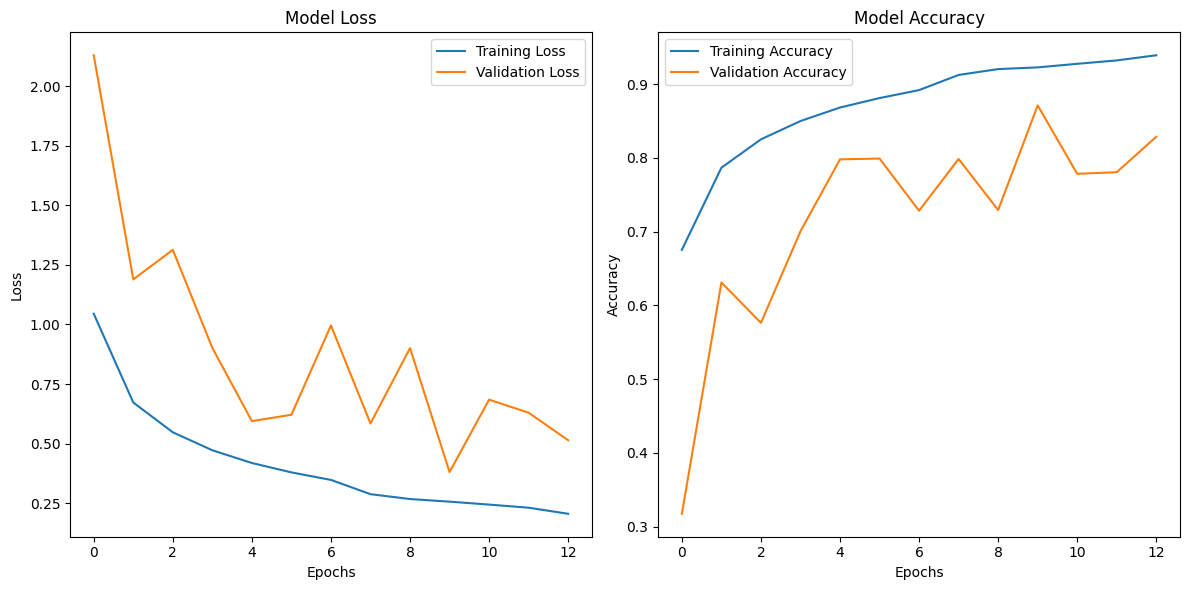

In [ ]:
# plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# Evaluation code

In [ ]:
# Generate Predictions on Test Set
from tensorflow.keras import Sequential

with keras.utils.custom_object_scope({'Sequential': Sequential}):
    model = keras.models.load_model('best_model_wo_augmentation.h5')
y_true = []
y_pred = []
y_score = []
for images, labels in ds_test_ohe:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_score.append(preds)
y_score = np.concatenate(y_score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Calculate Evaluation Metrics (Accuracy, Precision, Recall, F1)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import seaborn as sns
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-score: {f1:.6f}")


Accuracy: 0.871222
Precision: 0.902083
Recall: 0.871222
F1-score: 0.871887


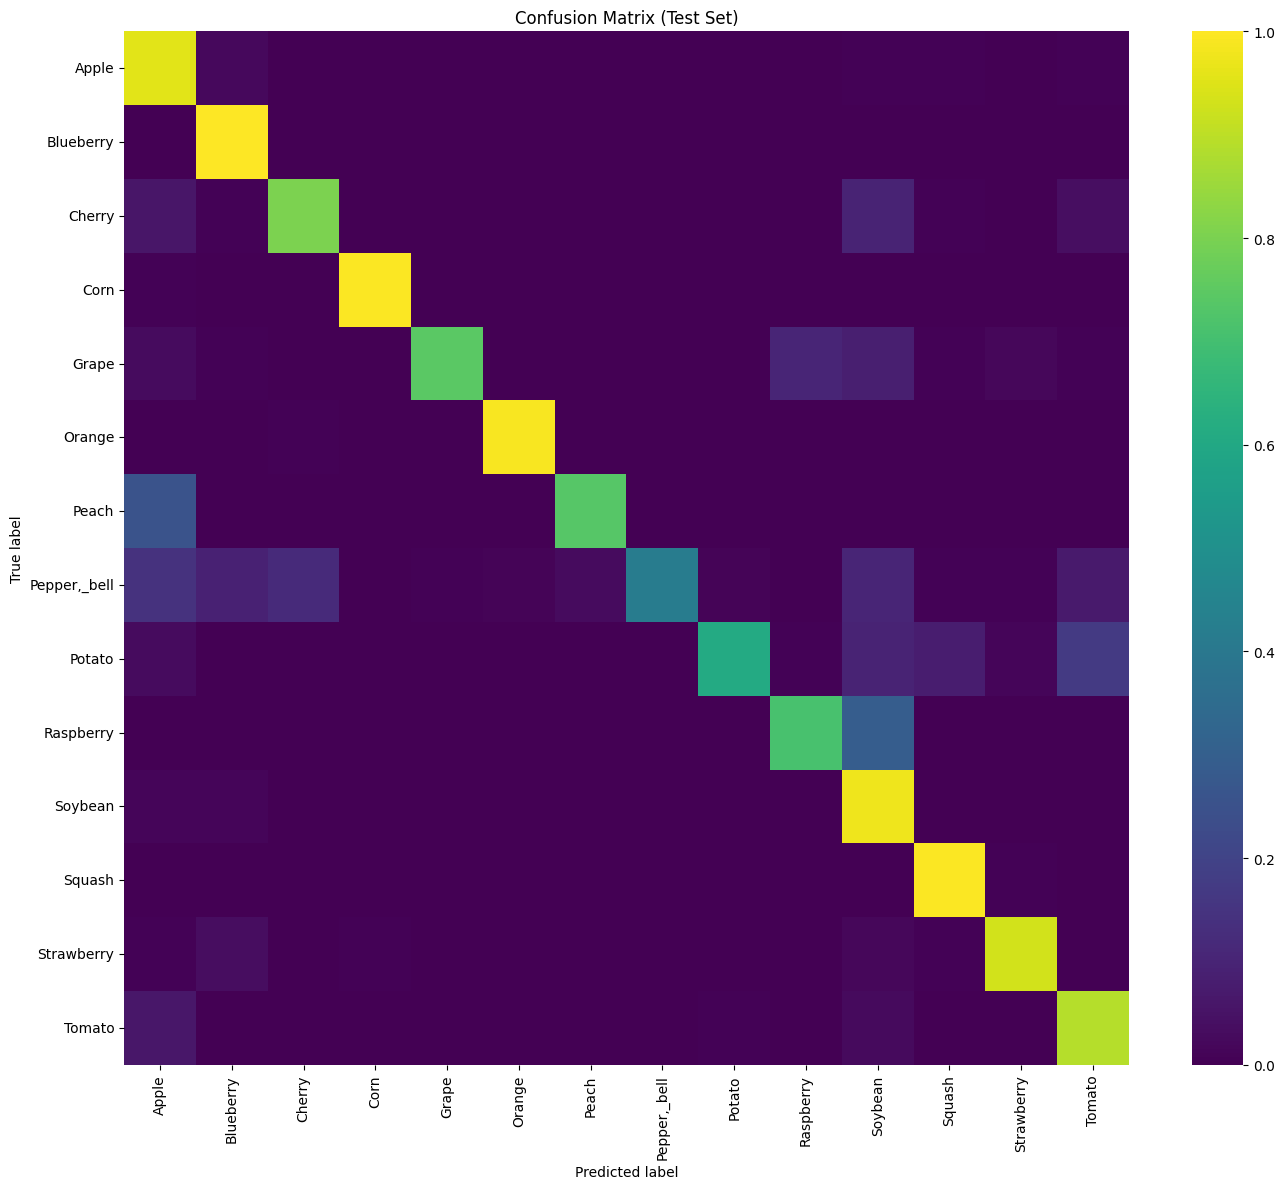

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')

#Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='viridis',
            xticklabels=split_labels, yticklabels=split_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Test Set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
print(y_score.shape[1])


14


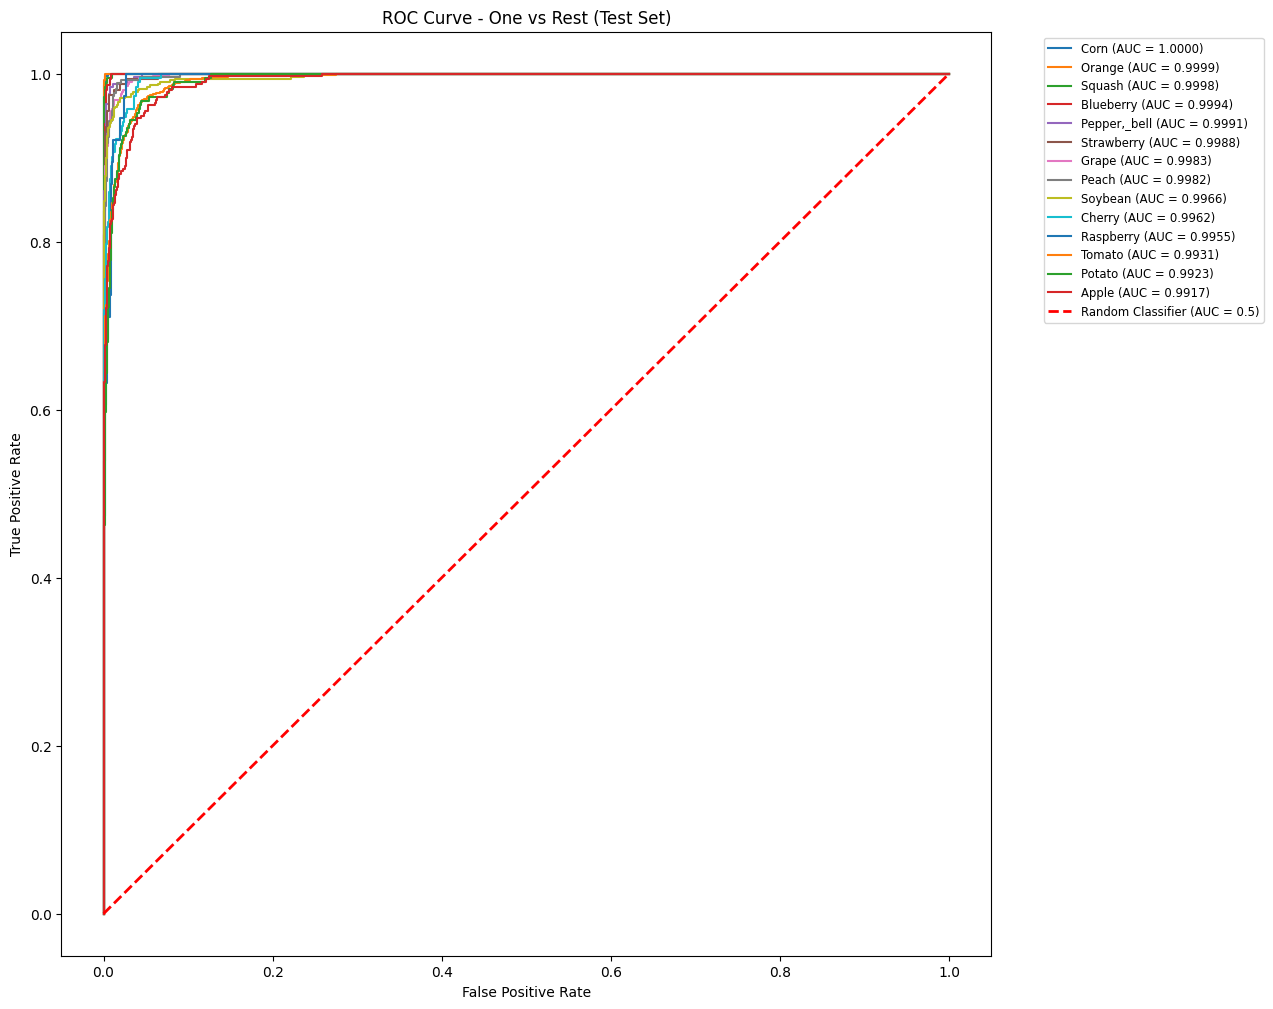

In [ ]:
# Plot ROC Curves for Each Class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.eye(n_classes)[y_true][:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(np.eye(n_classes)[y_true][:, i], y_score[:, i])
plt.figure(figsize=(12, 12))
auc_and_idx = sorted([(roc_auc[i], i) for i in range(n_classes)], reverse=True)
for auc, i in auc_and_idx:
    plt.plot(fpr[i], tpr[i], label=f'{split_labels[i]} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest (Test Set)')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='best')
plt.show()


In [ ]:
# Display Classification Report
report = classification_report(y_true, y_pred, target_names=split_labels)
print(report)


              precision    recall  f1-score   support

       Apple       0.55      0.96      0.69       319
   Blueberry       0.75      1.00      0.86       151
      Cherry       0.81      0.80      0.81       192
        Corn       0.98      0.99      0.99       388
       Grape       0.99      0.75      0.85       409
      Orange       0.99      0.99      0.99       552
       Peach       0.96      0.74      0.83       267
Pepper,_bell       1.00      0.42      0.59       250
      Potato       0.89      0.61      0.72       216
   Raspberry       0.38      0.71      0.50        38
     Soybean       0.75      0.98      0.85       509
      Squash       0.85      0.99      0.92       184
  Strawberry       0.90      0.93      0.91       159
      Tomato       0.96      0.89      0.92      1825

    accuracy                           0.87      5459
   macro avg       0.84      0.84      0.82      5459
weighted avg       0.90      0.87      0.87      5459

